In [1]:
#!/usr/bin/env python3 
# -*- coding: utf-8 -*-
"""------------------------------------------------------------------------
Matching of noisy simulations over multiple samples for statistical analysis 

Author: Emma Thomson
Year: 2020
Institution: Centre for Medical Image Computing: University College London
Email: e.thomson.19@ucl.ac.uk
------------------------------------------------------------------------"""

import numpy as np
import glob
import os 
from scipy.stats import iqr
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler
import itertools
import multiprocessing as mp
import time
import platform

import warnings
warnings.filterwarnings("ignore")

scaler = MinMaxScaler()



In [29]:
"""----------------------HELPER FUNCTIONS-----------------------------"""
def load_dictionary(dictionaryid, acqlen):
    print('Loading dictionary...')
    #fPath = os.path.join(os.getcwd(), 'dictionaries', 'Dictionary' + dictionaryid)
    #files = glob.glob(os.path.join(fPath, rr))
    fPath = os.path.join(os.getcwd(), 'dictionaries', 'Dictionary' + dictionaryid + '/dictionary.txt')
    no_entries = 94500 #len(files)
    raw_dictionary = np.genfromtxt(fPath, delimiter=',', dtype=None, encoding=None).T
    dictionary = np.zeros((acqlen, no_entries))
    #for count, filename in enumerate(files): # normalise the dictionary
    for i in range(no_entries):
        dictionary[:, i] = np.squeeze(raw_dictionary[:, i] / np.linalg.norm(raw_dictionary[:, i]))
        #dictionary[:, count] = np.squeeze(raw_dict[:acqlen] / np.linalg.norm(raw_dict[:acqlen]))
    print('Dictionary loaded')

    lPath = lPath = os.path.join(os.getcwd(), 'dictionaries', 'Dictionary' + dictionaryid, 'lookupTable.txt')
    lookup=np.loadtxt(lPath,delimiter=',', dtype=None, encoding=None) # shape = no_entries,no_params
    
    return dictionary,lookup #, files


def match_signal(test_name, dictionary, acqlen, noise, samples):
    hold = np.load(test_name)
    test_signal = hold[:acqlen, noise,:samples]
    # Normalise the test signal
    test_signal = test_signal / np.linalg.norm(test_signal)
    #Calculate the dot product 
    dot_sum = np.matmul(test_signal.T, dictionary[:acqlen, :])
    #dot_sum = dot_sum[dot_sum != 0]
    max_index = np.argmax(dot_sum, axis=1)
    print(max_index.shape)
    return max_index # return the index of the best dictionary match

def process_matching(params):
    T1t, T1b, T2t, T2b, res, per, multi, res_ave,res_std, res_est, dictionary, lookup, acqlen, samples = params
    for noise in range(res_ave.shape[0]): # number of noise levels is in the res_ave shape
        samp = 50
        perc = per/10
        test_name = './simulationData/noisy_ISMRM' + '/echo_' + str(T1t) + '_' + str(T1b) + '_' + str(T2t)+ '_' + str(T2b) + '_' +  str(res) + '_' + str(perc) + '_' + str(multi/100) + '_' + str(samp) + '.npy' 
        max_index = match_signal(test_name, dictionary, acqlen, noise, samples)
        matched_signal= lookup[max_index,:]
        res_est[:, :samp] = matched_signal.T
        res_ave[noise, :] = np.median(res_est[:, 1:], axis=1)
        res_std[noise, :] = iqr(res_est[:, 1:], axis=1)
    
    # Save results
    pc = [res_ave, res_std]
    print(pc)
    print([T1t, T1b, T2t, T2b, res, per, multi])
    file_name = f'./simulationData/noisy_ISMRM_matching/{T1t}_{T1b}_{T2t}_{T2b}_{res}_{perc}_{multi/100}_pc.npy'
    np.save(file_name, pc)
    # print results
    """
    print('Input signal')
    print(test_name)  
    print ('Matched:')
    print(str(res_ave[0,0]), str(res_ave[0,1]),
        str(res_ave[0,2]), str(res_ave[0,3]), str(res_ave[0,4]), str(res_ave[0,5]),str(res_ave[0,6]))
    """
    return pc


In [3]:
#go up a folder
os.chdir("..")
print(os.getcwd())

"""----------------------------INPUTS---------------------------------"""
#number of noise levels used in generation
noi = 2
#number of samples at each noise level used in generation
samples = 50
#length of signal
acqlen = 1000
#size of the dictionary - used for setting array size, can overestimate
no_entrys = 94500
#number of dimensions in the dictioanry
parameters = 7

#Name of the dictioanry
dictionaryid = 'FISP_WEX_ISMRM'
sampleid = dictionaryid

#load in dictionary 
#Load files
array = np.zeros((acqlen,no_entrys))

count = 0
sample = [0,0]
#rr = '*' +  str(repeat) + '.npy'
rr = '*_1.npy'
#Loading all signals

res_ave = np.zeros([noi,parameters])
res_std = np.zeros([noi,parameters])
res_est = np.zeros([parameters,samples])

dictionary, lookup = load_dictionary(dictionaryid, acqlen)


/Users/ela/Documents/PhD/code/MRFSGRE_BBB
Loading dictionary...
Dictionary loaded


In [28]:
## DEFINITION OF VARIATIONS FOR SIMULATION
# Specify the ranges and step sizes of the dictionary dimensions
# intravascular water residence time (res) UNIT: ms
resArray = range(200,1700,100) #range(200,1700,107) #range(200,1700,70) 
# percentage blood volume (perc) UNIT: %
percArray = range(10,110,10) #REMEMBER IT WILL BE DIVIDED BY 10 110
#T1 of tissue compartment (t1t) UNIT: ms
t1tArray = range(1000,2200,200) #range(700,1700,69) 
#T1 of blood compartment (t1b) UNIT: ms
t1bArray = range(1500,2100,200) #range(1540,1940,27) 
# multiplication factor for the B1 value (multi)
multiArray = range(80, 130, 10) #100
# T2 of tissue compartment UNIT: ms
t2tArray = range(38,127,15)
# T2 of blood compartment UNIT: ms
t2bArray = range(55, 385, 110)
if t2tArray[-1] > 112:
    t2tArray= list(t2tArray)
    t2tArray[-1] = 112
if percArray[-1] > 100:
    percArray= list(percArray)
    percArray[-1] = 100

# find mean T1 tissue and T1 blood
t1tmean = np.mean(t1tArray)
t1bmean = np.mean(t1bArray)
t2tmean = np.mean(t2tArray)
t2bmean = np.mean(t2bArray)

# remove params from the search space:
# if T1 tissue is above the mean, T2 tissue below the mean should be removed from list of params in itertools


# to iterate through all possible simulation values
params = list(itertools.product(t1tArray, t1bArray, t2tArray, t2bArray, resArray, percArray, multiArray))
filtered_combinations = [
(t1t, t1b, t2t, t2b, res, perc, multi) for t1t, t1b, t2t, t2b, res, perc, multi in params
if not (t1t > t1tmean and t2t < t2tmean) and not(t1b > t1bmean and t2b < t2bmean) and not (t2t > t2tmean and t1t < t1tmean) and not (t2b > t2bmean and t1b < t1bmean) 
]
params = filtered_combinations

##########################
otherParams = list([res_ave,res_std, res_est, dictionary,lookup, acqlen, samples])
# Verify the shape of params
otherParams = np.tile(np.array(otherParams, dtype=object),[np.size(params,0),1])
allParams = list(np.append(np.array(params), otherParams, axis=1)) 
#allParams = list(np.concatenate((np.array(params),np.array(otherParams, dtype=object)))) for one signal


In [34]:
print('Beginning matching...')
a = np.append(np.array(params), otherParams, axis=1)
print(a.shape)
for param in allParams:
    pc = process_matching(param)


Beginning matching...
(94500, 14)
(50,)
(50,)
[array([[1.00e+03, 1.50e+03, 3.80e+01, 5.50e+01, 2.00e+02, 1.00e+00,
        8.00e-01],
       [1.00e+03, 1.70e+03, 5.30e+01, 2.75e+02, 1.40e+03, 6.00e+00,
        8.00e-01]]), array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 200.,  15., 110., 300.,   4.,   0.]])]
[1000, 1500, 38, 55, 200, 10, 80]
(50,)
(50,)
[array([[1.00e+03, 1.50e+03, 3.80e+01, 5.50e+01, 2.00e+02, 1.00e+00,
        9.00e-01],
       [1.00e+03, 1.90e+03, 5.30e+01, 2.75e+02, 1.30e+03, 6.00e+00,
        9.00e-01]]), array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 200.,  15., 110., 500.,   3.,   0.]])]
[1000, 1500, 38, 55, 200, 10, 90]
(50,)
(50,)
[array([[1.00e+03, 1.50e+03, 3.80e+01, 5.50e+01, 2.00e+02, 1.00e+00,
        1.00e+00],
       [1.00e+03, 1.70e+03, 5.30e+01, 2.75e+02, 1.30e+03, 7.00e+00,
        1.00e+00]]), array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 200.,  30., 110., 500.,   4.,   0.]])]
[1000, 1500, 38, 55

KeyboardInterrupt: 

/Users/ela/Documents/PhD/code/MRFSGRE_BBB


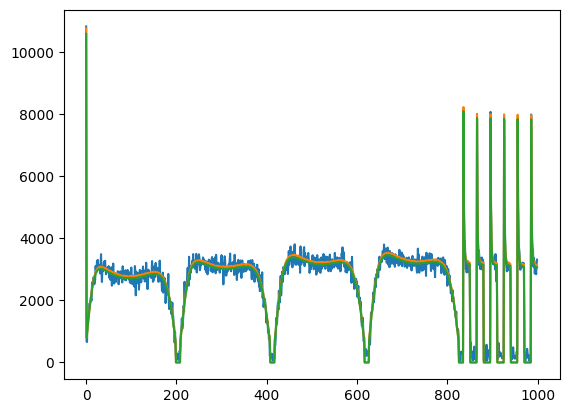

In [26]:
T1t, T1b, T2t, T2b, res, per, multi = params
print(os.getcwd())
noisy_testf = os.getcwd()+'/simulationData/noisy_ISMRM' + '/echo_' + str(T1t) + '_' + str(T1b) + '_' + str(T2t)+ '_' + str(T2b) + '_' +  str(res) + '_' + str(per/10) + '_' + str(multi/100) + '_' + '50' + '.npy' 
import matplotlib.pyplot as plt
noisy_test = np.load(noisy_testf)
plt.plot(noisy_test[:,1,1])
matched_signalf = os.getcwd()+'/simulationData/noisy_ISMRM' + '/echo_' + str(1000) + '_' + str(1700) + '_' + str(53)+ '_' + str(275) + '_' +  str(1400) + '_' + str(6.0) + '_' + str(0.8) + '_' + '50' + '.npy' 
matched_signal = np.load(matched_signalf)
plt.plot(matched_signal[:,0,1])
plt.plot(noisy_test[:,0,1])

In [36]:
pc = np.load('/Users/ela/Documents/PhD/code/MRFSGRE_BBB/simulationData/noisy_ISMRM_matching/1000_1700_38_275_500_9.0_1.0_pc.npy')
pc

array([[[1.00e+03, 1.70e+03, 3.80e+01, 2.75e+02, 5.00e+02, 9.00e+00,
         1.00e+00],
        [1.00e+03, 1.70e+03, 5.30e+01, 1.65e+02, 5.00e+02, 8.00e+00,
         1.00e+00]],

       [[0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00],
        [0.00e+00, 0.00e+00, 3.00e+01, 1.10e+02, 3.00e+02, 2.00e+00,
         0.00e+00]]])

In [ ]:

"""
if platform.system() == "Darwin":
    #If on local computer can use all CPUs
    pool = mp.Pool(12) #12
else:
    #If on cluster only use a few 
    pool = mp.Pool(8)

#Start timer
t0 = time.time()

#Run main function in parallel 
#Current laptop (2021 M1 Macbook Pro) will have 8 CPUs available
try:
    pool.map(process_matching, allParams)
finally:
    #Terminate and join the threads after parallelisation is done
    pool.terminate()
    pool.join()
    pool.close()

#Stop timer and print                                                    
t1 = time.time()
total = t1-t0
print(total)   
"""